# Model implementation for a single subject:

In [1]:
import pandas as pd
import numpy as np
import math
import os
import sys

## Importing custom functions from different folder:

In [2]:
# Get the current directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
folder = 'Implementation'
data_folder = os.path.join(parent_dir, folder)

# Construct the full file path
file_ = 'utils_data'
full_path = os.path.join(data_folder, file_)
print(full_path)
print(data_folder)
sys.path.append(data_folder)  

# Load the functions from .py file  
try:
    #from utils_data import load_data, data_clustering, plot_data, cleaning_data, linear_transf
    #from utils_data import experimental_velocity, plot_velocity, saving_processed_data
    from utils_data import load_processed_data, saving_processed_data
    from utils_model import numericalSimulation, ComputeFunctional, ComputeVel, generate_trajectory
    from utils_model import plot_simulation, generate_trajectory_vel, optimize_Sigma, plot_multiple_trajectories, fitParamaters
    
    from utils_model_multiple import plotting_params, box_plot_params, plot_gaussian_distributions_theo 
    
except ModuleNotFoundError as e:
    print("ModuleNotFoundError:", e)

/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation/utils_data
/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation


## Data exploration

The data considered on this notebook contains the trajectories for a single subject, for all the possible configurations, and for the different possible targets.

## Reproducing results

We can reproduce our results in this Notebook by setting the initial parameters as well as on the `main.py` file. 

Set the following parameters according to the study you wish to conduct: 
- `processing` when set to `True` it conducts the whole processing process from the raw data. This includes: 
    - `data_clustering`: 
        - Classifying the data in 4 clusters, depending on the target they cross using a RNN classifying algorithm. 
    - `cleaning_data`: 
        - Cleaning the trajectories which do not cross the target and truncating the ones which do cross it. Also storing the optimal time in which they reach the target, $T^*$, stored in `idxrule`
    - `linear_transf`:
        - Rotating the needed trajectories and scaling them in order to get normalized data
        - Computing the mean velocity and the velocity profiles for each trajectory

- `fitting` when set to `True` the fitting of the parameters is conducted with the already processed data. This includes: 
    - `fitParamaters`: 
        - Sequential approach: 
            1. Optimal movement duration: Generate the optimal trajectory by optimizing the Functional in terms of the time T 
            2. Optimal controller: generate the optimal trajectory with the optimal time duration by minimizing the functional in terms of the biomechanical parameters $(\alpha, \gamma, \varepsilon)$. 
            3. Stochastic optimization: generate the optimal trajectory with optimal time duration and biomechanical parameters by optimizing the Kolmogorov Sirnov estimate in terms of the sigma 
        - Saving the obtained parameters

- `plotting` when set to `True` all the trajectory plots and prints are explicitly shown on this Notebook
- `saving` when set to `True` all the plots and data processed is saved. 

In [3]:
processing = False
fitting = True
plotting = True
saving = False

# Loading processed data: 

In [4]:
if not processing:
    # Loading the processed data: 
    print('Loading processed data...')
    n_clusters = 4
    dfx = [[] for _ in range(n_clusters)]
    dfy = [[] for _ in range(n_clusters)]
    for cluster in range(n_clusters): 
        dfx[cluster] = load_processed_data(folder_path='processed_data', file_name='cluster{}_dfx.csv'.format(cluster))
        dfy[cluster] = load_processed_data(folder_path='processed_data', file_name='cluster{}_dfy.csv'.format(cluster))
    results = load_processed_data(folder_path='processed_data', file_name='results.csv') 

Loading processed data...


In [5]:
results

cluster                          rectx                      recty   
0        0      [ 9.5  10.75 11.5  12.75]          [6.6 7.6 3.1 4.1]  \
1        1  [-12.   -13.25 -10.   -11.25]  [-3.25 -4.25 -6.75 -7.75]   
2        2      [11.5  12.75  9.5  10.75]  [ 1.75  0.75 -1.75 -2.75]   
3        3  [ -9.5  -10.75 -11.5  -12.75]      [ 3.   4.  -0.5  0.5]   

                                             idxrule    mean_T   max_vel  
0  [1814, 1404, 1654, 1791, 1291, 1672, 1632, 171...  1.319448  0.005534  
1  [1698, 1554, 1868, 1708, 1313, 1274, 1455, 141...  1.295982  0.005831  
2  [1487, 1293, 1305, 1366, 1198, 1132, 1353, 128...  1.251862  0.004535  
3  [2042, 1197, 1369, 1063, 1131, 1495, 1305, 112...  1.304000  0.004591

# Parameter fitting: 

## Computing trajectories for optimized velocity for each cluster

Fitting paramaters for the optimized trajectory...
Computing trajectory with optimized velocity for cluser:  0


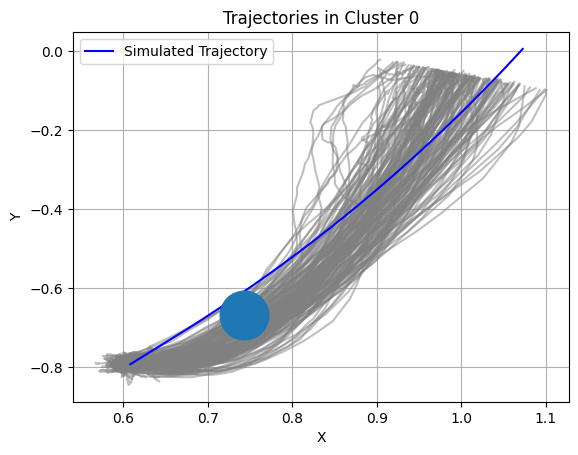

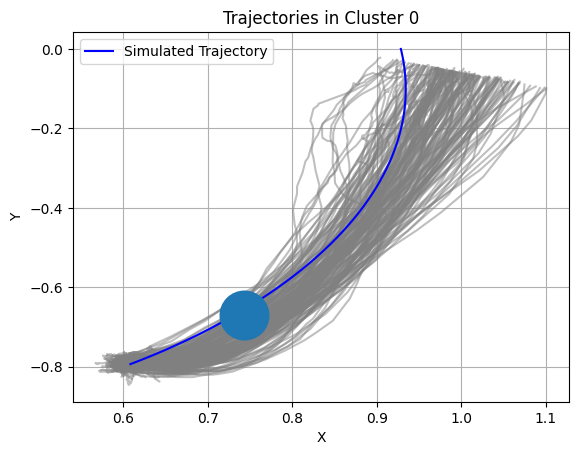

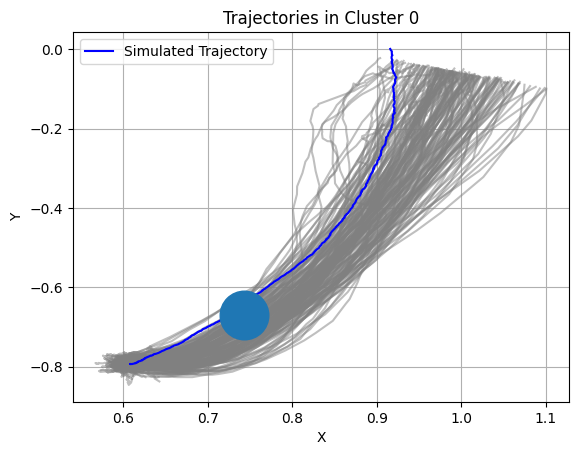

Parameters estimated:
[ 2.95749222  3.05271805 -3.21789397] 0.34131291624586024
Computing trajectory with optimized velocity for cluser:  1


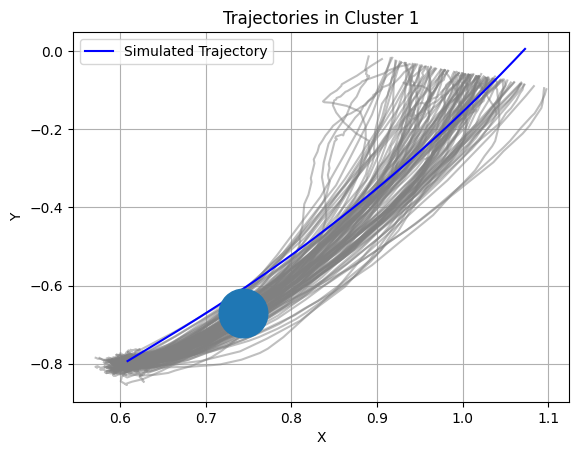

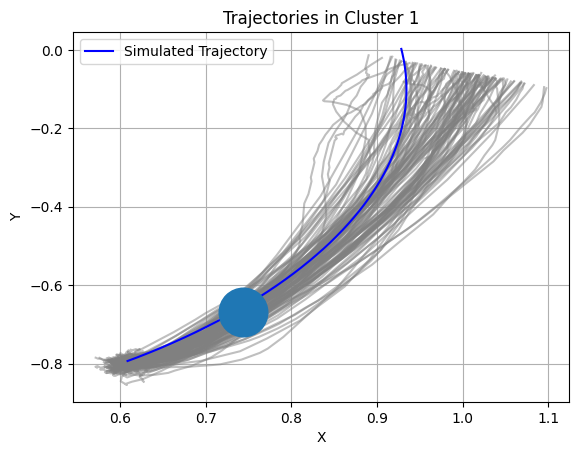

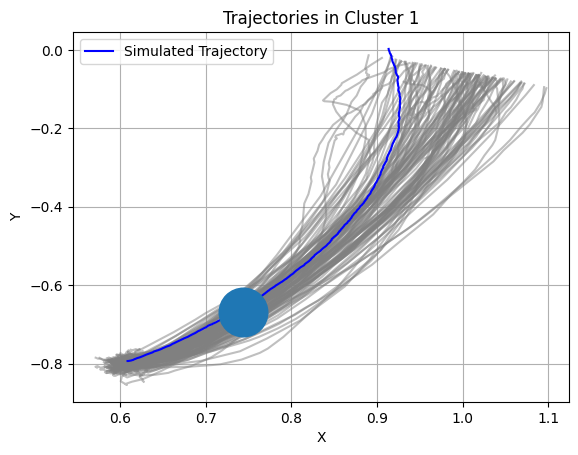

Parameters estimated:
[ 2.96624475  3.0617932  -3.22741432] 0.2360679772046799
Computing trajectory with optimized velocity for cluser:  2


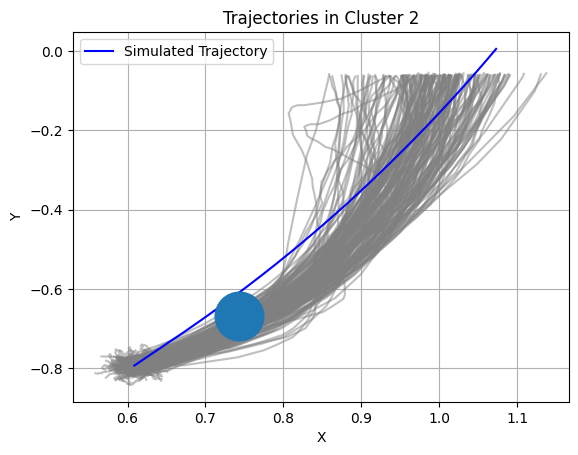

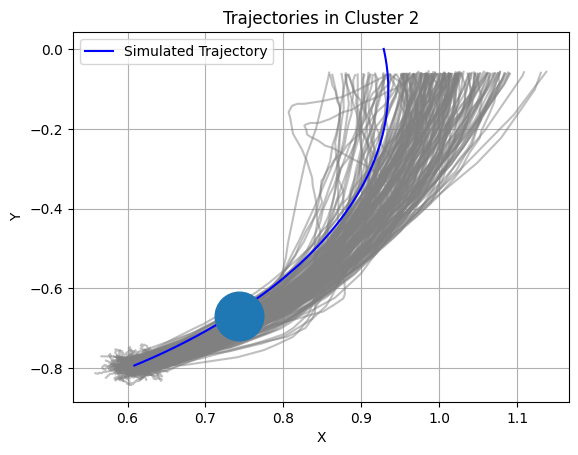

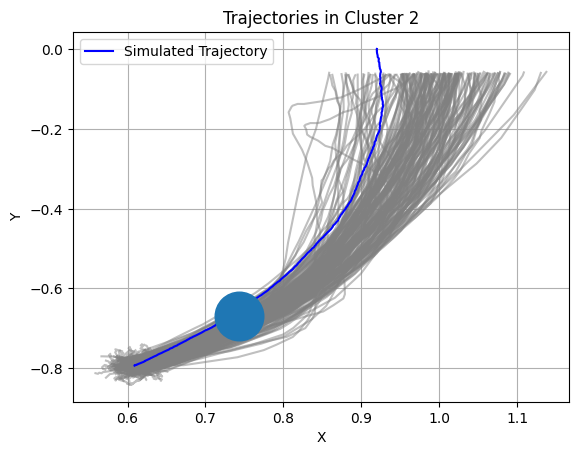

Parameters estimated:
[ 2.95038819  3.04836258 -3.21082698] 0.23662837654141022
Computing trajectory with optimized velocity for cluser:  3


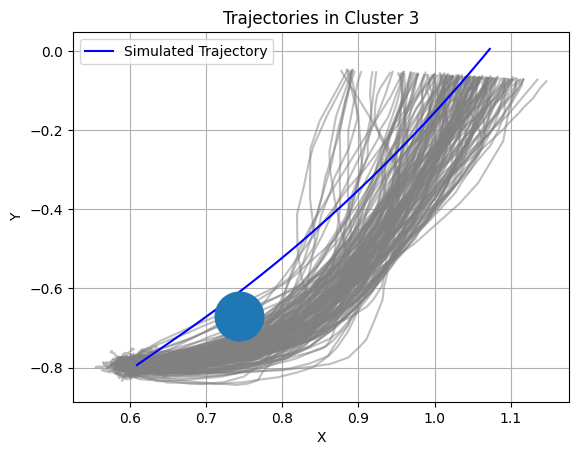

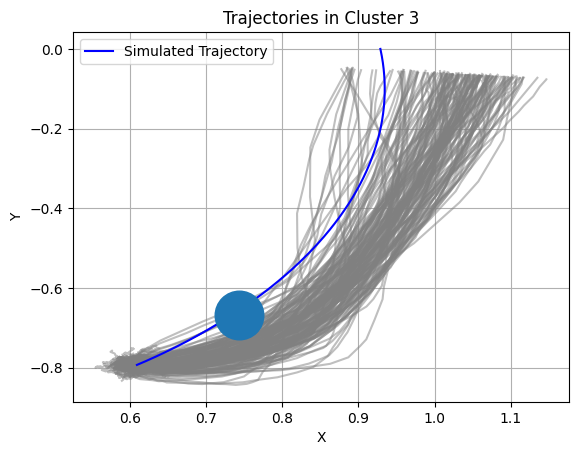

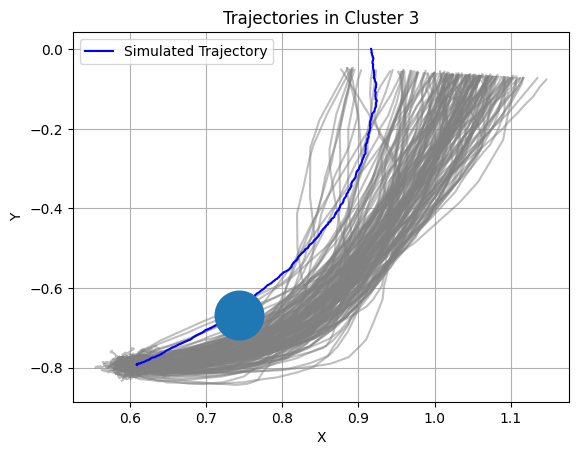

Parameters estimated:
[ 2.93367308  3.03112578 -3.18704439] 0.3292774335412911


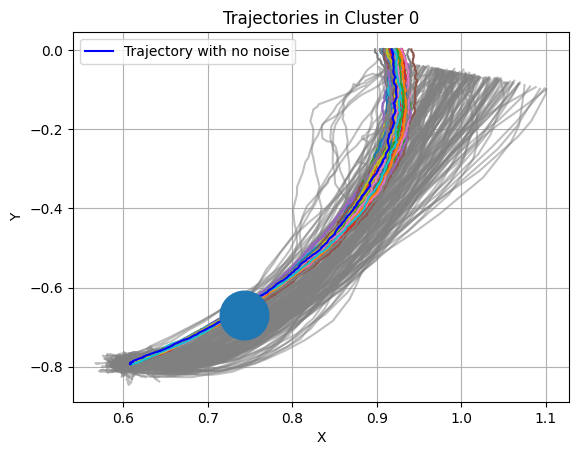

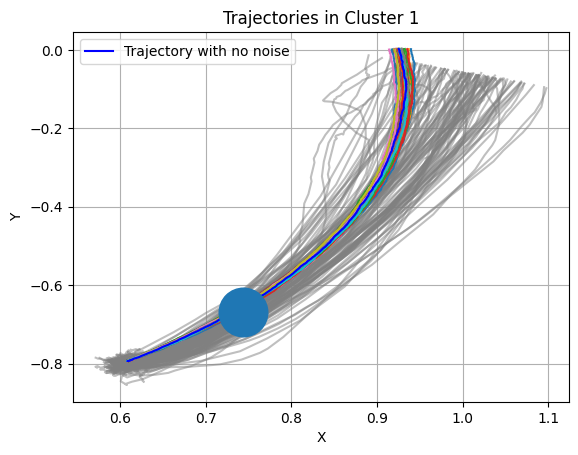

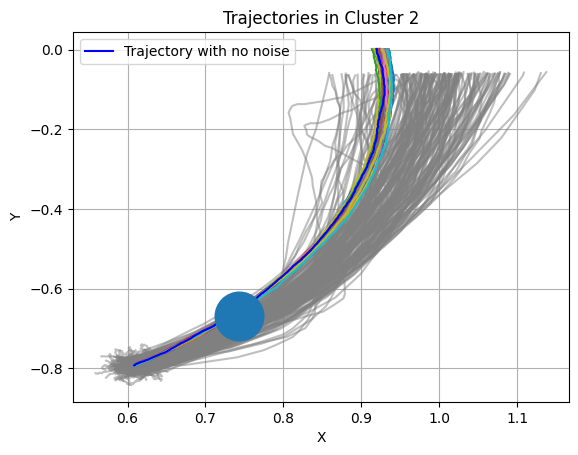

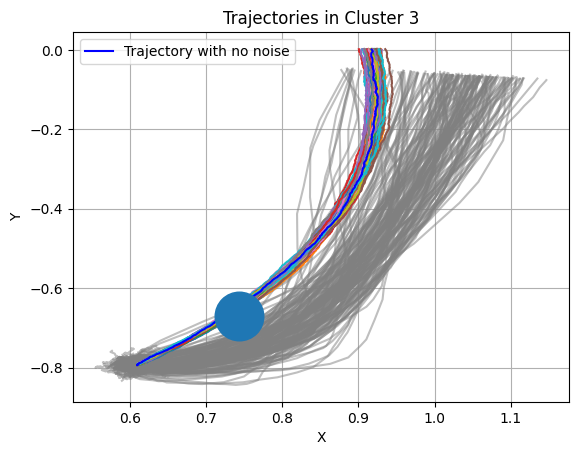

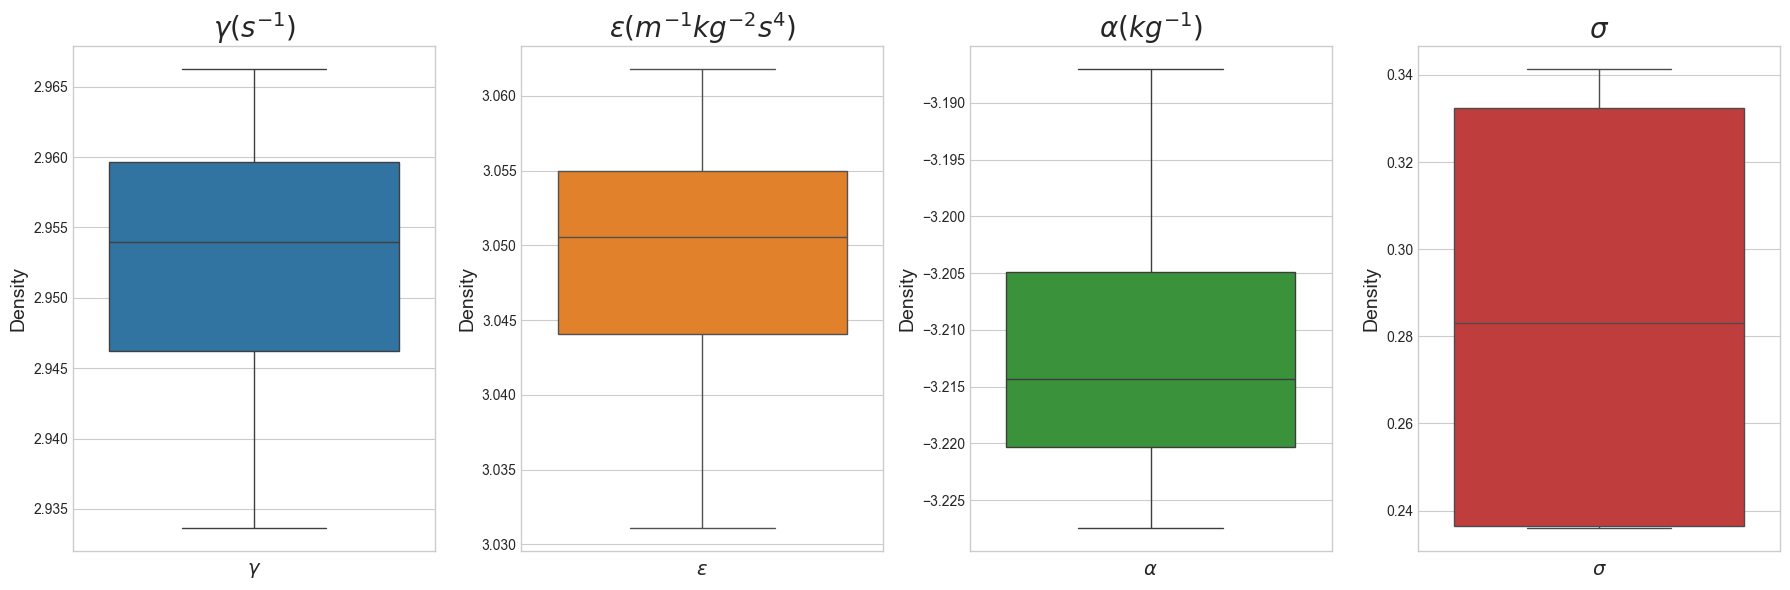

In [6]:
if fitting: 
    print('Fitting paramaters for the optimized trajectory...')   
    new_params, opt_sigma = fitParamaters(results, dfx, dfy, plotting = plotting, saving = saving)  
    combined_params = [] 
    for cluster in range(n_clusters):
        if plotting: 
            plot_multiple_trajectories(dfx[cluster], dfy[cluster], cluster = cluster, 
                               new_params = new_params[cluster], opt_Sigma = opt_sigma[cluster], 
                               pic_name = 'Simulated and experimental data', saving_plot = saving, 
                               pic_name = 'Trajectories_1')
        combined_params.append(np.hstack((new_params[cluster].x, opt_sigma[cluster].x)))
    parameters_fitted = pd.DataFrame(combined_params)
    params_fitted = np.array(combined_params)
    saving_processed_data(parameters_fitted, folder_name = 'fitted_data', file_name = 'fitted_parameters_2')
    if plotting: 
        box_plot_params(params_fitted, pic_name = 'parameters_boxplot_4', saving_plot= saving)

In [7]:
params_fitted

array([[ 2.95749222,  3.05271805, -3.21789397,  0.34131292],
       [ 2.96624475,  3.0617932 , -3.22741432,  0.23606798],
       [ 2.95038819,  3.04836258, -3.21082698,  0.23662838],
       [ 2.93367308,  3.03112578, -3.18704439,  0.32927743]])

### Function: 

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=0.6884099721898217, pvalue=0.49376251873629773)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9717651009559631, pvalue=0.852381706237793)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=0.7063600396237174, pvalue=0.4826103633803026)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9575011730194092, pvalue=0.7631832957267761)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=1.8144583554061242, pvalue=0.0744457395919127)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9390298128128052, pvalue=0.6484196782112122)
$\sigma$
T-test results:  Ttest_indResult(statistic=0.9738859373165252, pvalue=0.3338976399475704)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.7805522680282593, pvalue=0.0716724768280983)


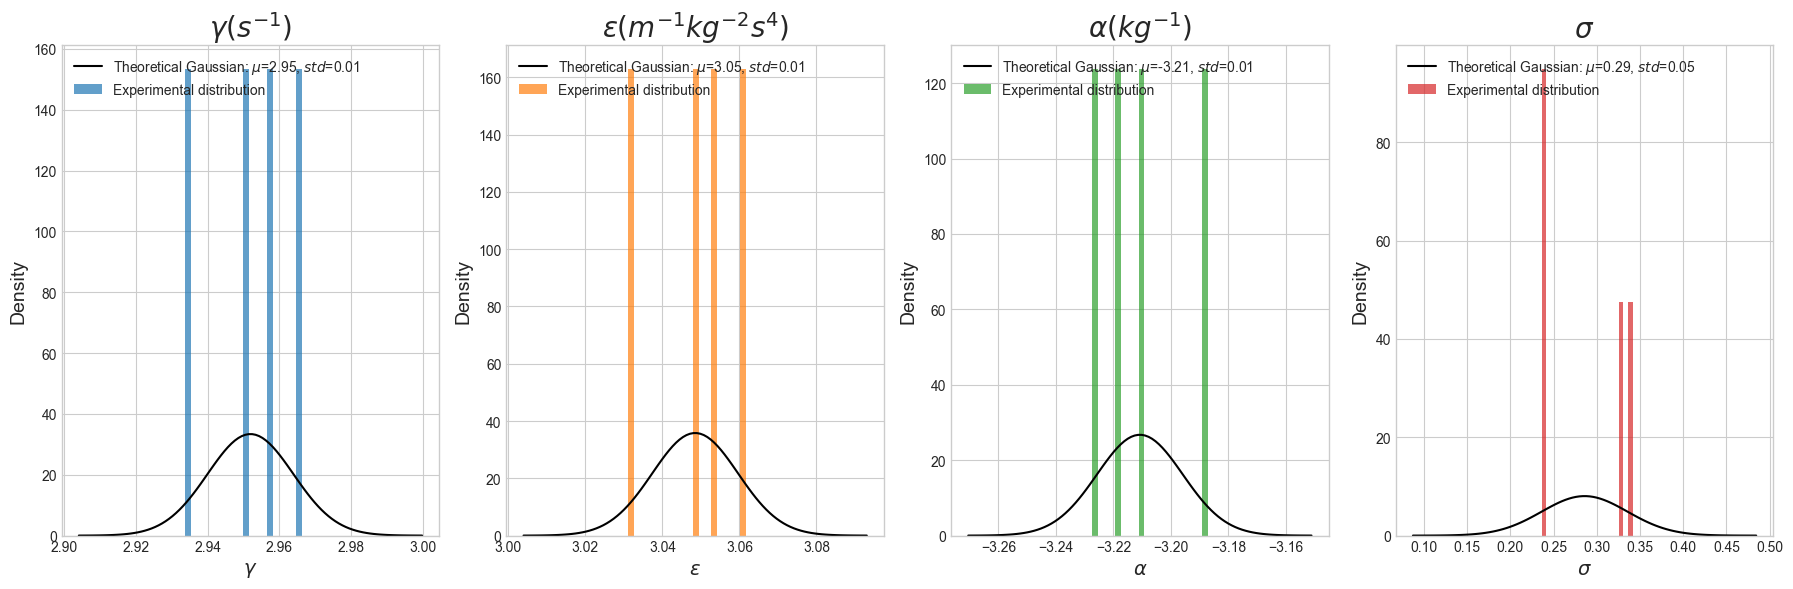

([Ttest_indResult(statistic=0.6884099721898217, pvalue=0.49376251873629773),
  Ttest_indResult(statistic=0.7063600396237174, pvalue=0.4826103633803026),
  Ttest_indResult(statistic=1.8144583554061242, pvalue=0.0744457395919127),
  Ttest_indResult(statistic=0.9738859373165252, pvalue=0.3338976399475704)],
 [ShapiroResult(statistic=0.9717651009559631, pvalue=0.852381706237793),
  ShapiroResult(statistic=0.9575011730194092, pvalue=0.7631832957267761),
  ShapiroResult(statistic=0.9390298128128052, pvalue=0.6484196782112122),
  ShapiroResult(statistic=0.7805522680282593, pvalue=0.0716724768280983)])

In [9]:
plot_gaussian_distributions_theo(params_fitted, style_label ='seaborn-whitegrid', 
                                     saving_plot = True,    folder_name = 'fitted_pics', 
                                     pic_name = 'params_gaussian_subject1_2', 
                                     )

In [8]:
new_params[cluster]

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3.0803674835926733
        x: [ 2.934e+00  3.031e+00 -3.187e+00]
      nit: 17
      jac: [-4.168e-01 -1.244e+00  9.032e-01]
 hess_inv: [[ 3.091e-01  2.927e-01 -3.977e-01]
            [ 2.927e-01  3.122e-01 -3.899e-01]
            [-3.977e-01 -3.899e-01  5.618e-01]]
     nfev: 304
     njev: 74

In [19]:
opt_sigma[cluster]

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.4901161193847656e-08 )
 success: True
     fun: 0.7530120481927711
       x: 0.3292774335412911
     nit: 41
    nfev: 46

# Functions

## Optimizing with parameter boundary limitations: 

In [10]:
import scipy
import matplotlib.pyplot as plt
from typing import Tuple

def plot_trajectory_(x, y, showing = True, via = True, plot_title = 'Simulated Trajectory'):
    '''
        Function that plots the given trajectory (x(t), y(t)). 
    ''' 
    plt.plot(x,y,color='blue', label=plot_title, alpha = 1)
    if via:
        angle=math.pi*7/24
        T_1=.2
        plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=35)
    if showing: 
        plt.show()

def generate_trajectory_vel_(params=(.5, .1, .5), parameters=(3.7, -0.15679707, 0.97252444, 0.54660283, -6.75775885, -0.06253371),
                            sigma=0, timestep=1/500, plotting=True, T=1.3, vel=0.1, 
                            bounds = [(0.01, 10), (0.01, 1), (0.01, 1)]  # Bounds for gamma, epsilon, alpha
                            ) -> Tuple[np.ndarray, np.ndarray]:
    
    partial_compute_vel = lambda params: ComputeVel(params, vel=vel, T=T, sigma=sigma)
    
    result = scipy.optimize.minimize(partial_compute_vel, params, bounds=bounds, method='L-BFGS-B')
    
    gamma, epsilon, alpha = result.x
    x, y, v, w, ux, uy, T = numericalSimulation(
        x_0=(0,0,0,0), p_T=1.0, sigma=sigma, gamma=gamma, epsilon=epsilon, alpha=alpha,
        u_0=parameters[:2], l_0=parameters[2:], i_max=1000, dt=timestep,
        Autoregr=True, Arc=True, angle=np.pi*7/24, angle0=0, p=(.2,0), r=.1
    )
    
    if plotting:
        plot_trajectory_(x, y, showing=True)
        
    return x, y, result


Computing trajectory with optimized velocity for cluster:  0


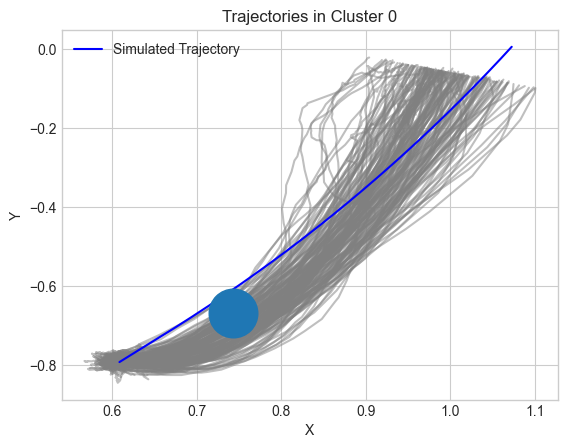

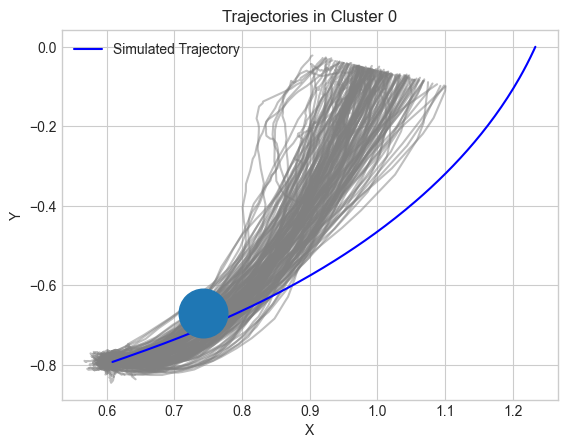

[10.         1.         0.0878486]
Computing trajectory with optimized velocity for cluster:  1


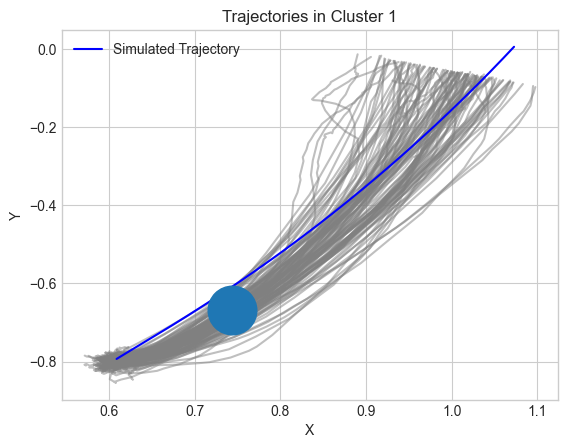

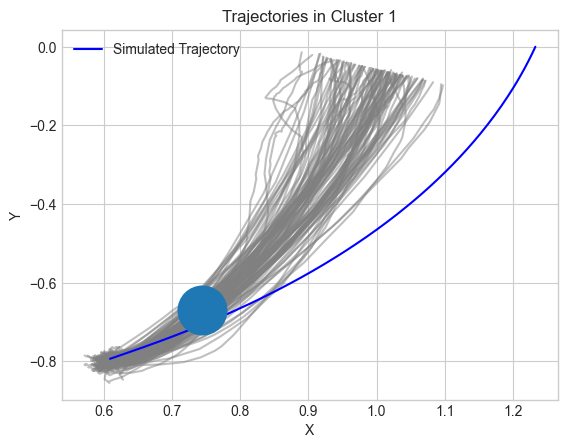

[10.          1.          0.08789306]
Computing trajectory with optimized velocity for cluster:  2


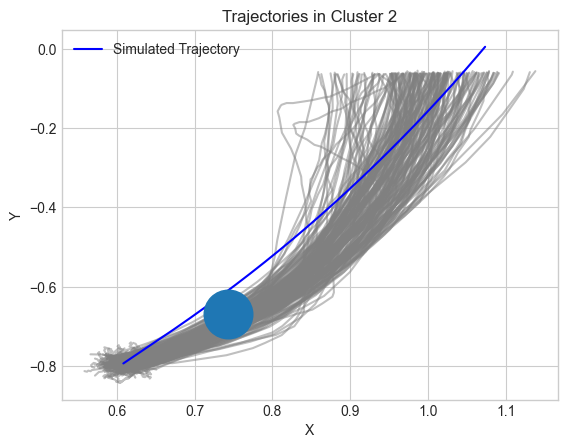

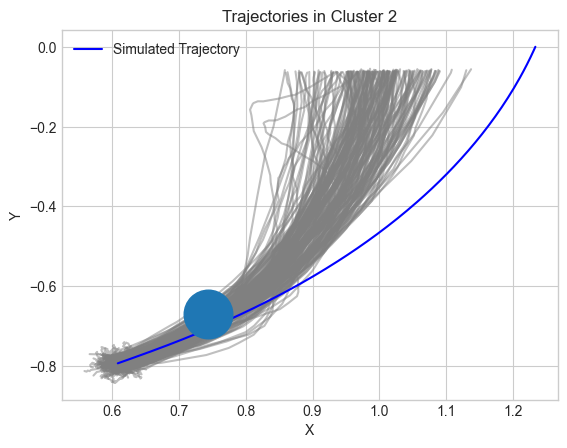

[10.         1.         0.0878494]
Computing trajectory with optimized velocity for cluster:  3


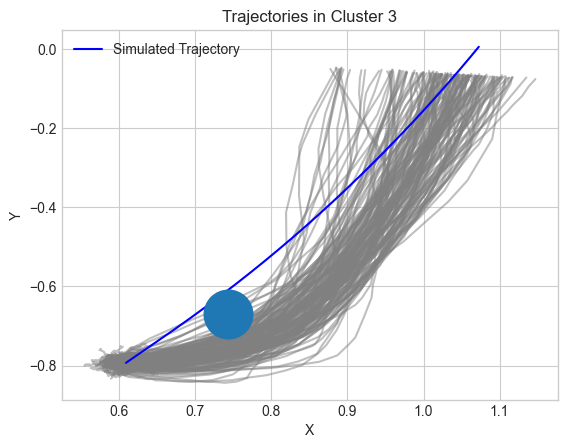

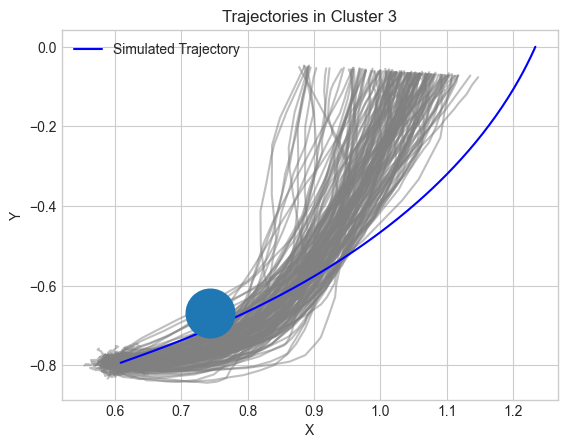

[10.          1.          0.08784861]


In [11]:
new_params_2 = [[] for _ in range(n_clusters)]
opt_sigma_2 = [[] for _ in range(n_clusters)]

for cluster in range(n_clusters):
    print('Computing trajectory with optimized velocity for cluster: ', cluster)
    
    ## Generate the optimal trajectory by optimizing the Functional in terms of the time T 
    x, y, T, params_0 = generate_trajectory(plotting = False)
    plot_simulation(x, y, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optFunctional', 
                    saving_plot = False)
    
    ## Generate the optimal trajectory with the time provided from optimizing the Functional 
    # by optimizing the velocity in terms of the parameters (alpha, epsilon, gamma)
    x_, y_, new_params_2[cluster] = generate_trajectory_vel_(plotting = False, 
                                 T = T,
                                 vel = results[results['cluster'] == cluster].max_vel.values[0])
    plot_simulation(x_, y_, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optVel', 
                    saving_plot = False)
    print(new_params_2[cluster].x)
    

In [12]:
new_params_2[cluster]

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17.573956227849475
        x: [ 1.000e+01  1.000e+00  8.785e-02]
      nit: 12
      jac: [-9.278e-02 -3.517e+01  2.282e+00]
     nfev: 316
     njev: 79
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Computing trajectory with optimized velocity for cluster:  0


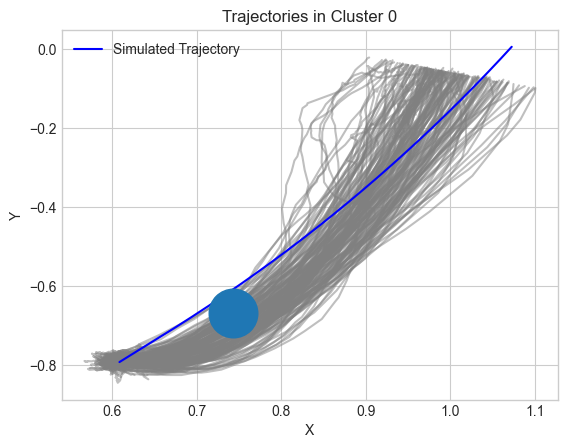

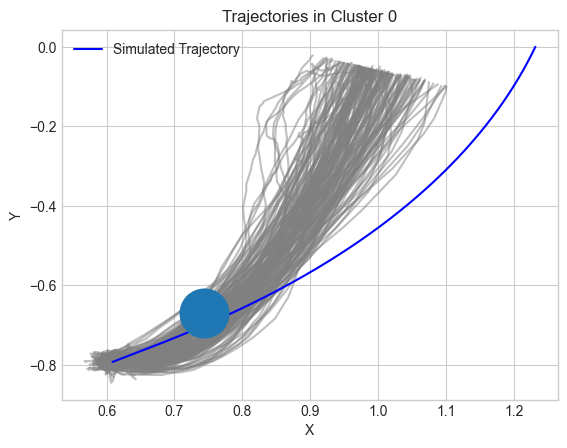

[ 6.26015198 10.          0.16754231]


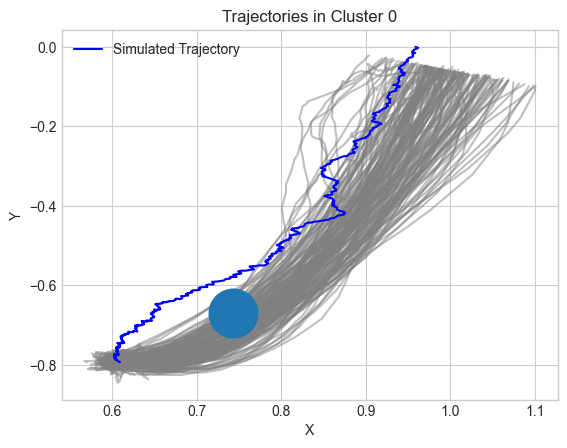

Parameters estimated:
[ 6.26015198 10.          0.16754231] 0.803852106778048
Computing trajectory with optimized velocity for cluster:  1


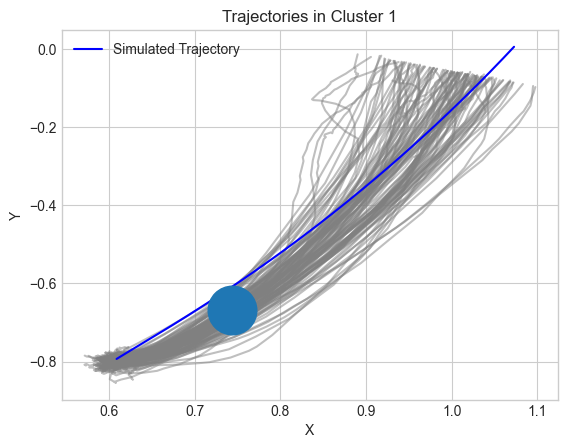

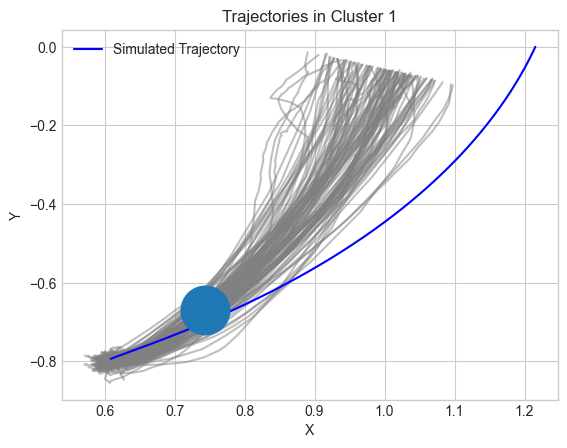

[5.79436659 5.61112639 0.15064788]


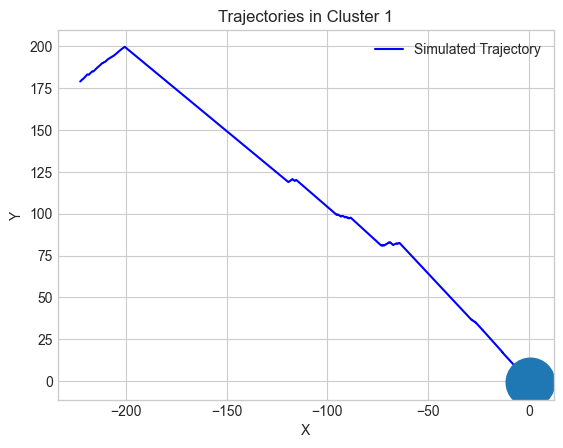

Parameters estimated:
[5.79436659 5.61112639 0.15064788] 7.798373971422981
Computing trajectory with optimized velocity for cluster:  2


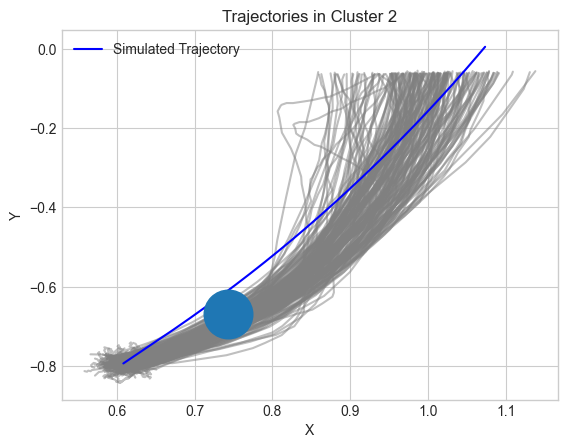

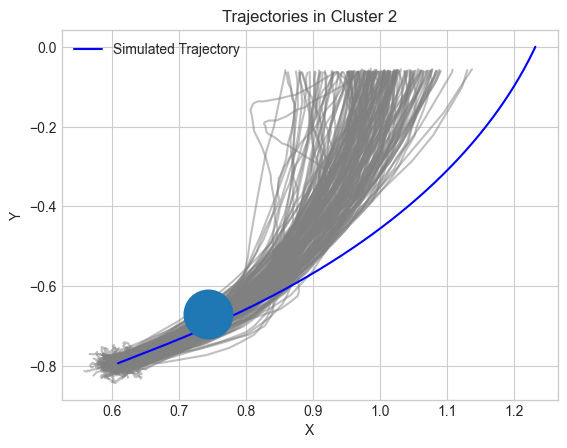

[ 6.26010523 10.          0.16752079]


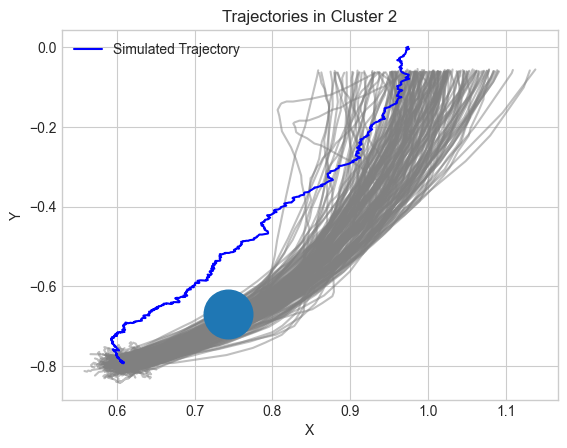

Parameters estimated:
[ 6.26010523 10.          0.16752079] 0.7981094484362812
Computing trajectory with optimized velocity for cluster:  3


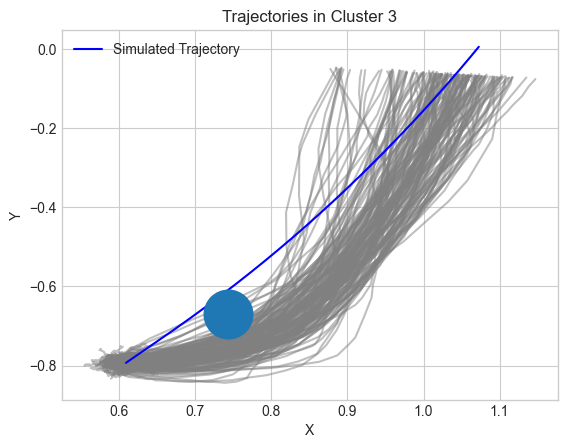

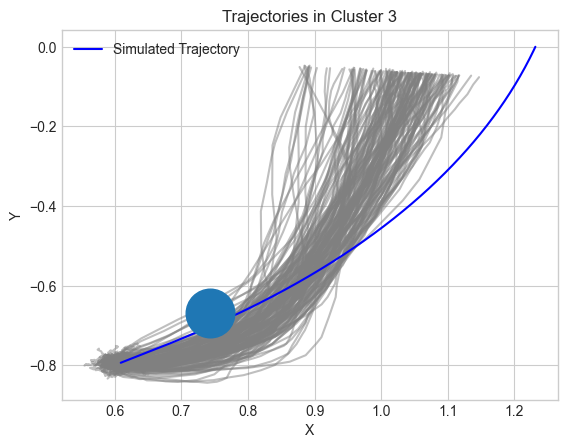

[ 6.26012077 10.          0.16752072]


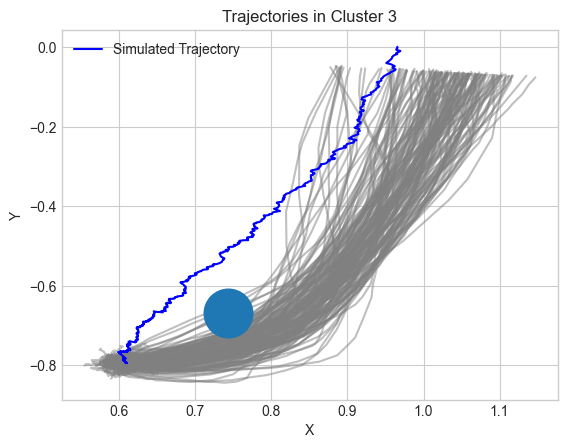

Parameters estimated:
[ 6.26012077 10.          0.16752072] 0.7847651549831289


In [14]:
for cluster in range(n_clusters):
    
    print('Computing trajectory with optimized velocity for cluster: ', cluster)
    
    ## Generate the optimal trajectory by optimizing the Functional in terms of the time T 
    x, y, T, params_0 = generate_trajectory(plotting = False)
    plot_simulation(x, y, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optFunctional', 
                    saving_plot = False)
    
    ## Generate the optimal trajectory with the time provided from optimizing the Functional 
    # by optimizing the velocity in terms of the parameters (alpha, epsilon, gamma)
    x_, y_, new_params_2[cluster] = generate_trajectory_vel_(plotting = False, 
                                 T = T,
                                 vel = results[results['cluster'] == cluster].max_vel.values[0], 
                                 bounds = [(0.001, 10), (0.001, 10), (0.001, 10)])
    plot_simulation(x_, y_, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optVel', 
                    saving_plot = False)
    print(new_params_2[cluster].x)
    idxr = results[results['cluster'] == cluster].idxrule.values[0]
    idxrule = np.fromstring(idxr[1: -1], dtype = int, sep = ', ')
    
    x__, y__, opt_sigma_2[cluster] = optimize_Sigma(dfx[cluster] , dfy[cluster],
                                        idxrule = idxrule, 
                                        new_params = new_params_2[cluster])
    if plotting: 
        plot_simulation(x__, y__, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optSigma', 
                    saving_plot = saving)
    
    print('Parameters estimated:')
    print(new_params_2[cluster].x, opt_sigma_2[cluster].x)

In [17]:
new_params_2[cluster]

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.146789537325583
        x: [ 6.260e+00  1.000e+01  1.675e-01]
      nit: 15
      jac: [-9.717e-02 -4.787e-01  2.641e+00]
     nfev: 688
     njev: 172
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [18]:
opt_sigma_2[cluster]

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.4901161193847656e-08 )
 success: True
     fun: 0.1566265060240964
       x: 0.7847651549831289
     nit: 39
    nfev: 44